In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Aggregation of MDSA scores complete.
Sample predictions for Model 0: [24.         24.          0.99879104]
Sample predictions for Model 1: [24.         24.          0.99689758]
Sample predictions for Model 2: [24.         24.          0.99958223]
Model 0 - preds.shape: (7841, 3)
Sample content of preds[0]: [34. 34.  1.]
Sample content of preds[1]: [24.         24.          0.99879104]
Model 1 - preds.shape: (7841, 3)
Sample content of preds[0]: [34.         34.          0.99999988]
Sample content of preds[1]: [24.         24.          0.99689758]
Model 2 - preds.shape: (7841, 3)
Sample content of preds[0]: [34.         34.          0.99827874]
Sample content of preds[1]: [24.         24.          0.99958223]
Shape of individual_preds after stacking: (7841, 3)


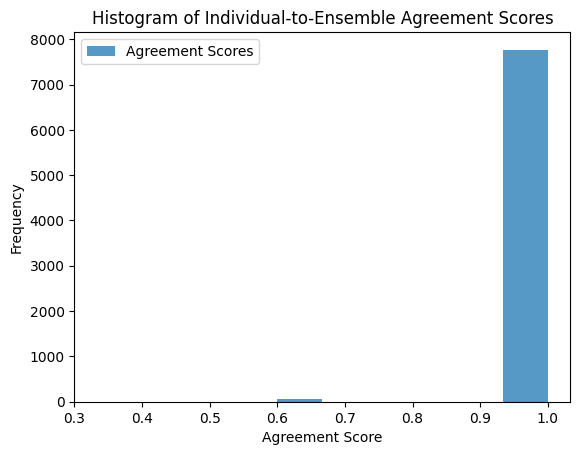


Sample of Lowest scores:
Input 1: 4.517534136755181
Input 2: 6.554309807793253
Input 3: 6.923253198307542
Input 4: 3.8933340810123234
Input 5: 4.494264352961433
Input 6: 4.529731715907902
Input 7: 5.611887781698953
Input 8: 6.189042553545991
Input 9: 3.9016012263221986
Input 10: 3.5981483024731937

Sample of Highest scores:
Input 1: 9.827767895474933
Input 2: 6.804878311110092
Input 3: 12.35305022240987
Input 4: 4.343385146758115
Input 5: 5.439303263059226
Input 6: 9.111805318795678
Input 7: 9.042813645883744
Input 8: 8.628319402800463
Input 9: 5.356266977754171
Input 10: 4.454059366168821

Sample of Average scores:
Input 1: 6.683753103490361
Input 2: 6.672659988148175
Input 3: 9.241652230619758
Input 4: 4.071591134623487
Input 5: 5.0139600883862725
Input 6: 6.782049164563106
Input 7: 7.362804485847941
Input 8: 7.222514157100215
Input 9: 4.793829464588993
Input 10: 3.9788659626293765


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Constants
AGGREGATED_SCORES_DIR = 'aggregated_scores'
os.makedirs(AGGREGATED_SCORES_DIR, exist_ok=True)
n_models = 3

# Load MDSA scores for all models
all_mdsa_scores = []
for i in range(n_models):
    score_filepath = f'/content/drive/MyDrive/layer_split_test_mdsa_scores_iter_{i}.npy'
    mdsa_scores = np.load(score_filepath)
    all_mdsa_scores.append(mdsa_scores)

# Stack all MDSA scores for aggregation
all_mdsa_scores = np.stack(all_mdsa_scores, axis=1)

# Apply aggregation methods
lowest_scores = np.min(all_mdsa_scores, axis=1)
highest_scores = np.max(all_mdsa_scores, axis=1)
average_scores = np.mean(all_mdsa_scores, axis=1)

# Save aggregated scores
np.save('/content/drive/MyDrive/layer_split_lowest_scores.npy', lowest_scores)
np.save('/content/drive/MyDrive/layer_split_highest_scores.npy', highest_scores)
np.save('/content/drive/MyDrive/layer_split_average_scores.npy', average_scores)

print('Aggregation of MDSA scores complete.')


def assign_surprise_labels(scores, threshold):
    return scores > threshold

# Load specific training data split for each model to calculate threshold
thresholds = []
for i in range(n_models):
    split_filepath = f'/content/drive/MyDrive/split_{i}.npz'
    with np.load(split_filepath) as data:
        train_mdsa_scores = np.load(f'/content/drive/MyDrive/layer_split_train_mdsa_scores_iter_{i}.npy')
        threshold_95th_percentile = np.percentile(train_mdsa_scores, 95)
        thresholds.append(threshold_95th_percentile)


# Assign surprise labels using individual model thresholds
lowest_surprise_labels = np.array([assign_surprise_labels(lowest_scores, threshold) for threshold in thresholds]).T
highest_surprise_labels = np.array([assign_surprise_labels(highest_scores, threshold) for threshold in thresholds]).T
average_surprise_labels = np.array([assign_surprise_labels(average_scores, threshold) for threshold in thresholds]).T

# Verify predictions and format of data in prediction files
for i in range(n_models):
    preds_filepath = f'/content/drive/MyDrive/layer_split_test_preds_iter_{i}.npy'
    preds = np.load(preds_filepath)
    print(f"Sample predictions for Model {i}: {preds[1][:10]}")

for i in range(n_models):
    preds_filepath = f'/content/drive/MyDrive/layer_split_test_preds_iter_{i}.npy'
    preds = np.load(preds_filepath)
    print(f"Model {i} - preds.shape: {preds.shape}")
    print(f"Sample content of preds[0]: {preds[0][:10]}")
    print(f"Sample content of preds[1]: {preds[1][:10]}")

# Load individual model prediction arrays for test set
individual_preds = []
for i in range(n_models):
    preds_filepath = f'/content/drive/MyDrive/layer_split_test_preds_iter_{i}.npy'
    preds = np.load(preds_filepath)
    # Extract all predicted class labels (not just one element) across samples
    predicted_labels = preds[:, 1].astype(int)  # Shape should be (7841,)
    individual_preds.append(predicted_labels)
individual_preds = np.stack(individual_preds, axis=1)

print(f"Shape of individual_preds after stacking: {individual_preds.shape}")  # Should be (7841, 3)

# Determine ensemble classification using majority voting
ensemble_preds_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=individual_preds)

# Calculate individual-to-ensemble agreement
def calculate_agreement(individual_labels, ensemble_labels):
    return individual_labels == ensemble_labels

individual_to_ensemble_agreement = np.mean([calculate_agreement(individual_preds[:, i], ensemble_preds_majority) for i in range(n_models)], axis=0)

# Plot the results
plt.hist(individual_to_ensemble_agreement, bins=10, alpha=0.75, label='Agreement Scores')
plt.xlabel('Agreement Score')
plt.ylabel('Frequency')
plt.title('Histogram of Individual-to-Ensemble Agreement Scores')
plt.legend()
plt.show()

# Print sample of the aggregated scores
def print_scores(scores, score_type, sample_size=10):
    print(f"\nSample of {score_type} scores:")
    for i, score in enumerate(scores[:sample_size]):
        print(f"Input {i+1}: {score}")

sample_size = 10
print_scores(lowest_scores, "Lowest", sample_size)
print_scores(highest_scores, "Highest", sample_size)
print_scores(average_scores, "Average", sample_size)


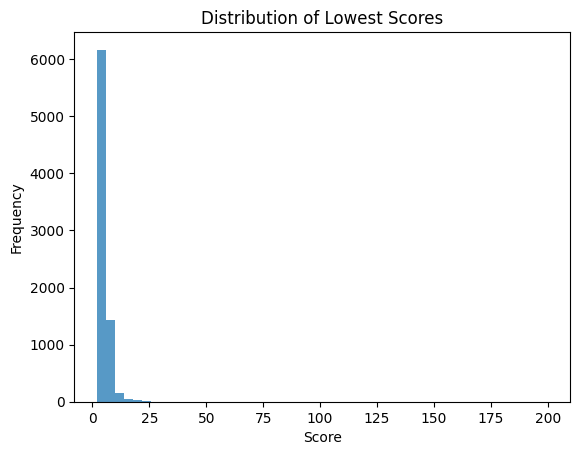

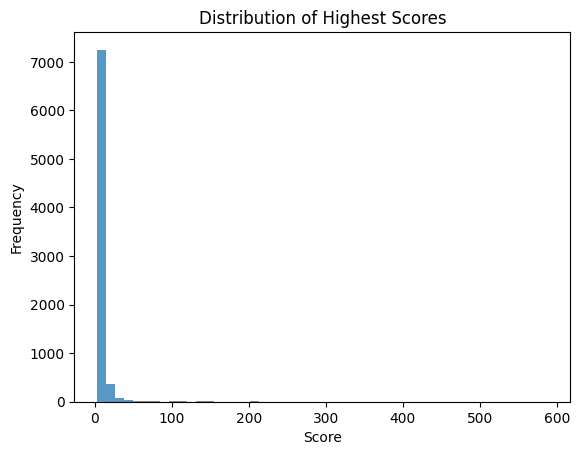

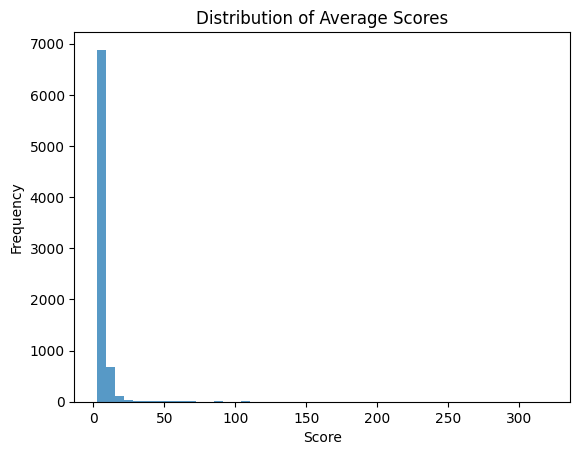

In [3]:
def plot_histogram(data, title, xlabel, ylabel):
    plt.hist(data, bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Plot distribution of aggregated scores
plot_histogram(lowest_scores, 'Distribution of Lowest Scores', 'Score', 'Frequency')
plot_histogram(highest_scores, 'Distribution of Highest Scores', 'Score', 'Frequency')
plot_histogram(average_scores, 'Distribution of Average Scores', 'Score', 'Frequency')




In [4]:
from sklearn.metrics import accuracy_score

# Load the GTSRB test data for reference ground truth labels
test_split_filepath = '/content/drive/MyDrive/test_data.npz'
with np.load(test_split_filepath) as data:
    y_test_labels_default = np.argmax(data['y_test'], axis=1)

# Verify and obtain ground truth labels from model predictions if consistent
individual_model_ground_truths = []
for i in range(n_models):
    preds_filepath = f'/content/drive/MyDrive/layer_split_test_preds_iter_{i}.npy'
    preds = np.load(preds_filepath)
    ground_truth_labels = preds[:, 0].astype(int)  # Using the first column as ground truth
    individual_model_ground_truths.append(ground_truth_labels)

# Ensure all models agree on ground truth labels
if all(np.array_equal(individual_model_ground_truths[0], gt) for gt in individual_model_ground_truths):
    y_test_labels = individual_model_ground_truths[0]
else:
    print("Warning: Ground truth labels differ across models, using default labels.")
    y_test_labels = y_test_labels_default

# Calculate classification accuracy for each model
individual_model_accuracies = []
for i in range(n_models):
    model_preds = individual_preds[:, i]
    individual_accuracy = accuracy_score(y_test_labels, model_preds)
    individual_model_accuracies.append(individual_accuracy)
    print(f"Classification accuracy of Model {i}: {individual_accuracy * 100:.2f}%")

# Calculate ensemble classification accuracy using majority voting
ensemble_accuracy = accuracy_score(y_test_labels, ensemble_preds_majority)
print(f"Classification accuracy of the ensemble model: {ensemble_accuracy * 100:.2f}%")

# Calculate and display average classification accuracy across models
average_model_accuracy = np.mean(individual_model_accuracies)
print(f"Average classification accuracy of individual models: {average_model_accuracy * 100:.2f}%")

# Display sample of predictions and ground truth labels for verification
print("Sample predictions for Model 0:", individual_preds[:10, 0])
print("Sample ground truth labels:", y_test_labels[:10])


Classification accuracy of Model 0: 99.43%
Classification accuracy of Model 1: 99.71%
Classification accuracy of Model 2: 99.80%
Classification accuracy of the ensemble model: 99.89%
Average classification accuracy of individual models: 99.64%
Sample predictions for Model 0: [34 24 21 12 25 18 34  2 15 40]
Sample ground truth labels: [34 24 21 12 25 18 34  2 15 40]


In [5]:
import pandas as pd

# Prepare data for CSV
# Assuming 'preds' files contain [ground_truth, prediction, confidence]
results_data = {
    "Model_0_Pred": individual_preds[:, 0],
    "Model_1_Pred": individual_preds[:, 1],
    "Model_2_Pred": individual_preds[:, 2],
    "Ground_Truth": y_test_labels,
    "Ensemble_Pred": ensemble_preds_majority
}

# Add confidence scores if needed
for i in range(n_models):
    preds_filepath = f'/content/drive/MyDrive/layer_split_test_preds_iter_{i}.npy'
    preds = np.load(preds_filepath)
    results_data[f"Model_{i}_Confidence"] = preds[:, 2]  # Assuming confidence scores are in the third column

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_data)

# Save the DataFrame to a CSV file
csv_filepath = '/content/drive/MyDrive/predictions_results.csv'
results_df.to_csv(csv_filepath, index=False)

print(f"Results saved to {csv_filepath}")


Results saved to /content/drive/MyDrive/predictions_results.csv


In [6]:
from sklearn.metrics import accuracy_score

# List to store surprise accuracy of each model
individual_surprise_accuracies = []

# Calculate surprise accuracy for each model and store the results
for i in range(n_models):
    preds_filepath = f'/content/drive/MyDrive/layer_split_test_preds_iter_{i}.npy'
    preds = np.load(preds_filepath)

    # Generate surprise labels for each sample using the model's threshold
    # This labels each sample as surprising (1) or not surprising (0) based on the threshold
    model_mdsa_scores = average_scores  # or lowest/highest scores if you're testing those aggregations
    individual_surprise_labels = assign_surprise_labels(model_mdsa_scores, thresholds[i])

    # Calculate incorrect classifications: 1 if incorrect, 0 if correct
    # Here, 1 means surprising, and it should ideally match with incorrect classifications
    incorrect_classifications = (y_test_labels != individual_preds[:, i]).astype(int)

    # Calculate surprise accuracy by checking alignment between incorrect classifications
    # and the surprise labels
    surprise_accuracy = accuracy_score(incorrect_classifications, individual_surprise_labels)
    individual_surprise_accuracies.append(surprise_accuracy)
    print(f"Surprise accuracy of Model {i}: {surprise_accuracy}")

# Calculate and print the average surprise accuracy across all models
average_surprise_accuracy = np.mean(individual_surprise_accuracies)
print(f"Average surprise accuracy of individual models: {average_surprise_accuracy}")


Surprise accuracy of Model 0: 0.9348297411044509
Surprise accuracy of Model 1: 0.9279428644305573
Surprise accuracy of Model 2: 0.9306210942481826
Average surprise accuracy of individual models: 0.9311312332610636


In [7]:
from sklearn.metrics import accuracy_score

# Check initial shape
print("Shape of individual_surprise_labels before stacking:", individual_surprise_labels.shape)

# Initialize a list to store each model's surprise labels
individual_surprise_labels_list = []

# Generate surprise labels for each model based on the threshold and the chosen aggregated scores
for i in range(n_models):
    # Use the same aggregated scores (average, lowest, or highest) as in the previous cells
    model_mdsa_scores = average_scores  # adjust if using lowest_scores or highest_scores
    model_surprise_labels = assign_surprise_labels(model_mdsa_scores, thresholds[i])
    individual_surprise_labels_list.append(model_surprise_labels)

# Stack the labels to form a 2D array: (num_samples, n_models)
individual_surprise_labels = np.stack(individual_surprise_labels_list, axis=1)
print("Shape of individual_surprise_labels after stacking:", individual_surprise_labels.shape)

# Determine ensemble surprise label using majority voting on individual surprise labels
ensemble_surprise_labels_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=individual_surprise_labels.astype(int))

# Determine ensemble prediction using majority voting
ensemble_preds_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=individual_preds)

# Calculate incorrect classifications for the ensemble
ensemble_incorrect_classifications = (y_test_labels != ensemble_preds_majority).astype(int)

# Calculate surprise accuracy for the ensemble as alignment between ensemble's surprise labels and incorrect classifications
ensemble_surprise_accuracy = accuracy_score(ensemble_incorrect_classifications, ensemble_surprise_labels_majority)
print(f"Surprise accuracy of the ensemble model: {ensemble_surprise_accuracy:}")


Shape of individual_surprise_labels before stacking: (7841,)
Shape of individual_surprise_labels after stacking: (7841, 3)
Surprise accuracy of the ensemble model: 0.9297283509756409


In [8]:
# Define function to calculate TP, FN, FP, TN with surprise labels
def calculate_tf_pn_with_surprise(labels, preds, scores, thresholds, n_models):
    for i in range(n_models):
        print(f"\nCalculating TP, FN, FP, TN for Model {i} (with surprise labels)")
        model_pred = preds[:, i]  # Predictions for model i
        model_scores = scores[:, i]  # Surprise scores for model i
        model_thresh = thresholds[i]  # Threshold for model i

        # Determine correct and incorrect classifications (1 if correct, 0 if incorrect)
        correct_classifications = (labels == model_pred).astype(int)
        surprise_labels = model_scores > model_thresh  # 1 if surprising, 0 if not

        # Calculate TP, FN, FP, TN with surprise label alignment
        tp = np.sum((correct_classifications == 0) & (surprise_labels == 1))
        fn = np.sum((correct_classifications == 0) & (surprise_labels == 0))
        fp = np.sum((correct_classifications == 1) & (surprise_labels == 1))
        tn = np.sum((correct_classifications == 1) & (surprise_labels == 0))

        print(f"Model {i} - TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")

# Run the function to calculate and print TP, FN, FP, TN with surprise labels for each model
calculate_tf_pn_with_surprise(
    labels=y_test_labels,
    preds=individual_preds,
    scores=all_mdsa_scores,  # Surprise scores
    thresholds=thresholds,
    n_models=n_models
)



Calculating TP, FN, FP, TN for Model 0 (with surprise labels)
Model 0 - TP: 45, FN: 0, FP: 522, TN: 7274

Calculating TP, FN, FP, TN for Model 1 (with surprise labels)
Model 1 - TP: 23, FN: 0, FP: 536, TN: 7282

Calculating TP, FN, FP, TN for Model 2 (with surprise labels)
Model 2 - TP: 16, FN: 0, FP: 553, TN: 7272


In [17]:
# Define function to calculate TP, FN, FP, TN for ensemble
def calculate_tf_pn_ensemble(labels, preds, scores, threshold):
    print(f"\nCalculating TP, FN, FP, TN for Ensemble Model (with surprise labels)")
    ensemble_scores = scores.mean(axis=1)  # Ensemble surprise scores (average)
    surprise_labels = ensemble_scores > threshold  # 1 if surprising, 0 if not

    # Determine correct and incorrect classifications (1 if correct, 0 if incorrect)
    correct_classifications = (labels == preds).astype(int)

    # Calculate TP, FN, FP, TN with surprise label alignment
    tp = np.sum((correct_classifications == 0) & (surprise_labels == 1))
    fn = np.sum((correct_classifications == 0) & (surprise_labels == 0))
    fp = np.sum((correct_classifications == 1) & (surprise_labels == 1))
    tn = np.sum((correct_classifications == 1) & (surprise_labels == 0))

    print(f"Ensemble - TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")
    return tp, fn, fp, tn

# Calculate and print TP, FN, FP, TN for ensemble model
ensemble_threshold = np.percentile(lowest_scores, 95)  # Example threshold (adjust as needed)
calculate_tf_pn_ensemble(
    labels=y_test_labels,
    preds=ensemble_preds_majority,
    scores=all_mdsa_scores,
    threshold=ensemble_threshold
)



Calculating TP, FN, FP, TN for Ensemble Model (with surprise labels)
Ensemble - TP: 9, FN: 0, FP: 1028, TN: 6804


(9, 0, 1028, 6804)

In [19]:
# Define percentiles for multiple thresholds
percentiles = [70 ,80, 90, 95, 99]  # Add or adjust percentiles as needed

# Generate new thresholds for individual models and ensemble
new_thresholds_list = [{i: np.percentile(all_mdsa_scores[:, i], p) for i in range(n_models)} for p in percentiles]
new_ensemble_thresholds = [np.percentile(all_mdsa_scores.mean(axis=1), p) for p in percentiles]

# Function to recalculate TP, FN, FP, TN for individual models and ensemble with multiple thresholds
def recalculate_tf_pn_with_multiple_thresholds(labels, preds, scores, thresholds_list, ensemble_thresholds, n_models):
    for p_idx, thresholds in enumerate(thresholds_list):  # Loop through each threshold set
        print(f"\nThreshold Percentile: {percentiles[p_idx]}%")

        # Individual models
        for i in range(n_models):
            print(f"\nModel {i} with Threshold {percentiles[p_idx]}%")
            model_pred = preds[:, i]
            model_scores = scores[:, i]
            new_thresh = thresholds[i]

            # Determine correct and incorrect classifications (1 if correct, 0 if incorrect)
            correct_classifications = (labels == model_pred).astype(int)
            surprise_labels = model_scores > new_thresh

            # Calculate TP, FN, FP, TN
            tp = np.sum((correct_classifications == 0) & (surprise_labels == 1))
            fn = np.sum((correct_classifications == 0) & (surprise_labels == 0))
            fp = np.sum((correct_classifications == 1) & (surprise_labels == 1))
            tn = np.sum((correct_classifications == 1) & (surprise_labels == 0))

            print(f"Model {i} - TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")

        # Ensemble model
        ensemble_threshold = ensemble_thresholds[p_idx]
        print(f"\nEnsemble with Threshold {percentiles[p_idx]}%")
        ensemble_scores = scores.mean(axis=1)  # Ensemble surprise scores (average)
        surprise_labels = ensemble_scores > ensemble_threshold  # 1 if surprising, 0 if not

        # Determine correct and incorrect classifications (1 if correct, 0 if incorrect)
        correct_classifications = (labels == ensemble_preds_majority).astype(int)

        # Calculate TP, FN, FP, TN
        tp = np.sum((correct_classifications == 0) & (surprise_labels == 1))
        fn = np.sum((correct_classifications == 0) & (surprise_labels == 0))
        fp = np.sum((correct_classifications == 1) & (surprise_labels == 1))
        tn = np.sum((correct_classifications == 1) & (surprise_labels == 0))

        print(f"Ensemble - TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")

# Run recalculation for all thresholds
recalculate_tf_pn_with_multiple_thresholds(
    labels=y_test_labels,
    preds=individual_preds,
    scores=all_mdsa_scores,
    thresholds_list=new_thresholds_list,
    ensemble_thresholds=new_ensemble_thresholds,
    n_models=n_models
)



Threshold Percentile: 70%

Model 0 with Threshold 70%
Model 0 - TP: 45, FN: 0, FP: 2307, TN: 5489

Model 1 with Threshold 70%
Model 1 - TP: 23, FN: 0, FP: 2329, TN: 5489

Model 2 with Threshold 70%
Model 2 - TP: 16, FN: 0, FP: 2336, TN: 5489

Ensemble with Threshold 70%
Ensemble - TP: 9, FN: 0, FP: 2343, TN: 5489

Threshold Percentile: 80%

Model 0 with Threshold 80%
Model 0 - TP: 45, FN: 0, FP: 1523, TN: 6273

Model 1 with Threshold 80%
Model 1 - TP: 23, FN: 0, FP: 1545, TN: 6273

Model 2 with Threshold 80%
Model 2 - TP: 16, FN: 0, FP: 1552, TN: 6273

Ensemble with Threshold 80%
Ensemble - TP: 9, FN: 0, FP: 1559, TN: 6273

Threshold Percentile: 90%

Model 0 with Threshold 90%
Model 0 - TP: 45, FN: 0, FP: 739, TN: 7057

Model 1 with Threshold 90%
Model 1 - TP: 23, FN: 0, FP: 761, TN: 7057

Model 2 with Threshold 90%
Model 2 - TP: 16, FN: 0, FP: 768, TN: 7057

Ensemble with Threshold 90%
Ensemble - TP: 9, FN: 0, FP: 775, TN: 7057

Threshold Percentile: 95%

Model 0 with Threshold 95%
M

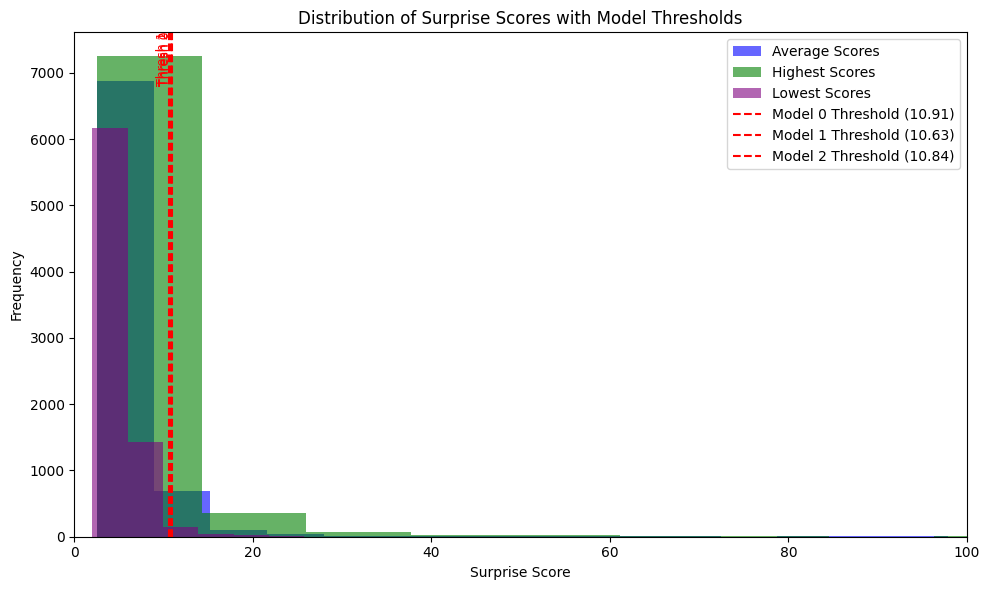

In [9]:
import matplotlib.pyplot as plt

# Plot the distribution of all surprise scores (using lowest, highest, and average scores)
plt.figure(figsize=(10, 6))

# Plot histogram of average surprise scores across all instances
plt.hist(average_scores, bins=50, alpha=0.6, label='Average Scores', color='blue')

# Plot histogram of highest surprise scores across all instances
plt.hist(highest_scores, bins=50, alpha=0.6, label='Highest Scores', color='green')

# Plot histogram of lowest surprise scores across all instances
plt.hist(lowest_scores, bins=50, alpha=0.6, label='Lowest Scores', color='purple')

# Plot and annotate thresholds for each model in red
for i, threshold in enumerate(thresholds):
    if threshold <= 100:  # Only plot if threshold is within the range
        plt.axvline(threshold, color='red', linestyle='--', label=f'Model {i} Threshold ({threshold:.2f})')
        plt.text(threshold, plt.ylim()[1]*0.9, f'Thresh {i}', color='red', ha='right', rotation=90, fontsize=9)


plt.xlim(0, 100)

plt.xlabel('Surprise Score')
plt.ylabel('Frequency')
plt.title('Distribution of Surprise Scores with Model Thresholds')
plt.legend()
plt.tight_layout()
plt.show()
